In [ ]:
#Improve Plotting of PCA Loadings
#Create a sample fixed income portfolio using quantlib
#Run regression to find sensitivity to Yield curve changes - i.e duration
#Hedge overlays
#Alphs generation - How to leverage PCA for generating alpha - If 10Yr is moving idiosyncraticly; how much to buy/sell based on PC3 (Butterfly)

In [49]:
from openbb import obb
import pandas as pd
import numpy as np
from scipy.stats import norm
import datetime as dt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import QuantLib as ql
import matplotlib.pyplot as plt
import plotly as pl
import plotly.graph_objects as go

In [29]:
def FetchRates(Start_Date=None, End_Date=None):
    treasury_data = obb.fixedincome.government.treasury_rates(start_date=Start_Date, end_date=End_Date, provider="federal_reserve").to_df()
    fed_funds = obb.fixedincome.rate.effr(start_date=Start_Date, end_date=End_Date, provider="federal_reserve").to_df()[['rate']].rename(columns={'rate': 'FedFunds'})
    sofr_data = obb.fixedincome.rate.sofr(start_date=Start_Date, end_date=End_Date, provider="federal_reserve").to_df()[['rate']].rename(columns={'rate': 'SOFR'})

    #Merge
    rates_data = treasury_data.join([fed_funds, sofr_data], how='outer')
    #Reset Index
    rates_data = rates_data.rename_axis('Date').reset_index()

    #Renaming Columns
    rates_data.rename(columns={
        "month_1": "1Mo", "month_2": "2Mo", "month_3": "3Mo", "month_6": "6Mo", 
        "year_1": "1Yr", "year_2": "2Yr", "year_3": "3Yr", 
        "year_5": "5Yr", "year_7": "7Yr", "year_10": "10Yr", "year_30": "30Yr"
    }, inplace=True)

    # Filter and Sort
    cols = ['Date', 'FedFunds', 'SOFR', '1Mo', '3Mo', '6Mo', '1Yr', '2Yr', '3Yr', '5Yr', '7Yr', '10Yr', '30Yr']
    rates_data = rates_data[cols].sort_values('Date')

    # Removing rows where primary benchmarks are missing (weekends/holidays)
    rates_data = rates_data.dropna(subset=['FedFunds', '1Mo'])
    
    # Forward Fill SOFR (Modern syntax)
    rates_data['SOFR'] = rates_data['SOFR'].ffill()
    
    return rates_data

In [30]:
# Filter for rows that contain any NaN values
#null_rows = rates_data[rates_data.isnull().any(axis=1)]
#null_rows

In [31]:
start_date = "2023-12-01"
end_date = dt.datetime.today().strftime('%Y-%m-%d')
rates_data=FetchRates(start_date, end_date)

In [32]:
def calculate_rolling_pca_multi(df, window): 
    tenors = ['1Mo', '3Mo', '6Mo', '1Yr', '2Yr', '3Yr', '5Yr', '7Yr', '10Yr', '30Yr']
    diff_df = df[tenors].diff() 
    
    results = []
    loadings_flat = [] # This will store 30 values per date
    dates = []
    
    for i in range(window + 1, len(df)):
        window_data = diff_df.iloc[i-window:i].dropna()
        
        scaler = StandardScaler()
        scaled_window = scaler.fit_transform(window_data)
        
        pca = PCA(n_components=3)
        pca.fit(scaled_window)
        
        # 1. Store Explained Variance
        results.append(pca.explained_variance_ratio_)
        
        # 2. Flatten Loadings: (3, 10) becomes (30,)
        # It flattens in order: PC1_1Mo...PC1_30Yr, PC2_1Mo...PC2_30Yr, etc.
        loadings_flat.append(pca.components_.flatten())
        
        dates.append(df['Date'].iloc[i-1]) 
    
    # Create the Explained Variance DataFrame
    rolling_var_df = pd.DataFrame(
        results, 
        columns=['PC1_Level', 'PC2_Slope', 'PC3_Curvature'], 
        index=dates
    )
    
    # 3. Create the MultiIndex for Columns
    # This creates a hierarchy: Level/Tenor, Slope/Tenor, Curvature/Tenor
    multi_col = pd.MultiIndex.from_product(
        [['PC1_Level', 'PC2_Slope', 'PC3_Curvature'], tenors], 
        names=['Component', 'Tenor']
    )
    
    # Create the Loadings DataFrame
    rolling_loadings_df = pd.DataFrame(
        loadings_flat, 
        columns=multi_col, 
        index=dates
    )
    
    return rolling_var_df, rolling_loadings_df

# Execute
rolling_window = 20 # ~3 months of trading days
rolling_var, rolling_loadings = calculate_rolling_pca_multi(rates_data, rolling_window)

In [50]:
# 1. Create the figure
fig = go.Figure()

# 2. Add traces for each Principal Component
# We use high-contrast colors for a professional dashboard look
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
components = ['PC1_Level', 'PC2_Slope', 'PC3_Curvature']

for col, color in zip(components, colors):
    fig.add_trace(go.Scatter(
        x=rolling_var.index, 
        y=rolling_var[col],
        mode='lines',
        name=col.replace('_', ': '),
        line=dict(width=2, color=color),
        hovertemplate='%{y:.2%}' # Formats hover as percentage
    ))

# 3. Update the layout for a "Terminal" look
fig.update_layout(
    title=dict(
        text=f'<b>{rolling_window}-Day Rolling PCA: Explained Variance</b>',
        x=0.5,
        font=dict(size=20)
    ),
    xaxis_title="Date",
    yaxis_title="Percentage of Total Variance",
    template="plotly_white", # Clean white background
    hovermode="x unified",     # Shows all 3 values when hovering on a date
    legend=dict(
        orientation="h", 
        yanchor="bottom", y=1.02, 
        xanchor="right", x=1
    ),
    margin=dict(l=50, r=50, t=100, b=50),
    height=600
)

# 4. Format Y-axis as percentages (e.g., 95.0%)
fig.update_layout(yaxis_tickformat='.1%')

<Axes: title={'center': 'Evolution of Level (PC1) Loadings'}>

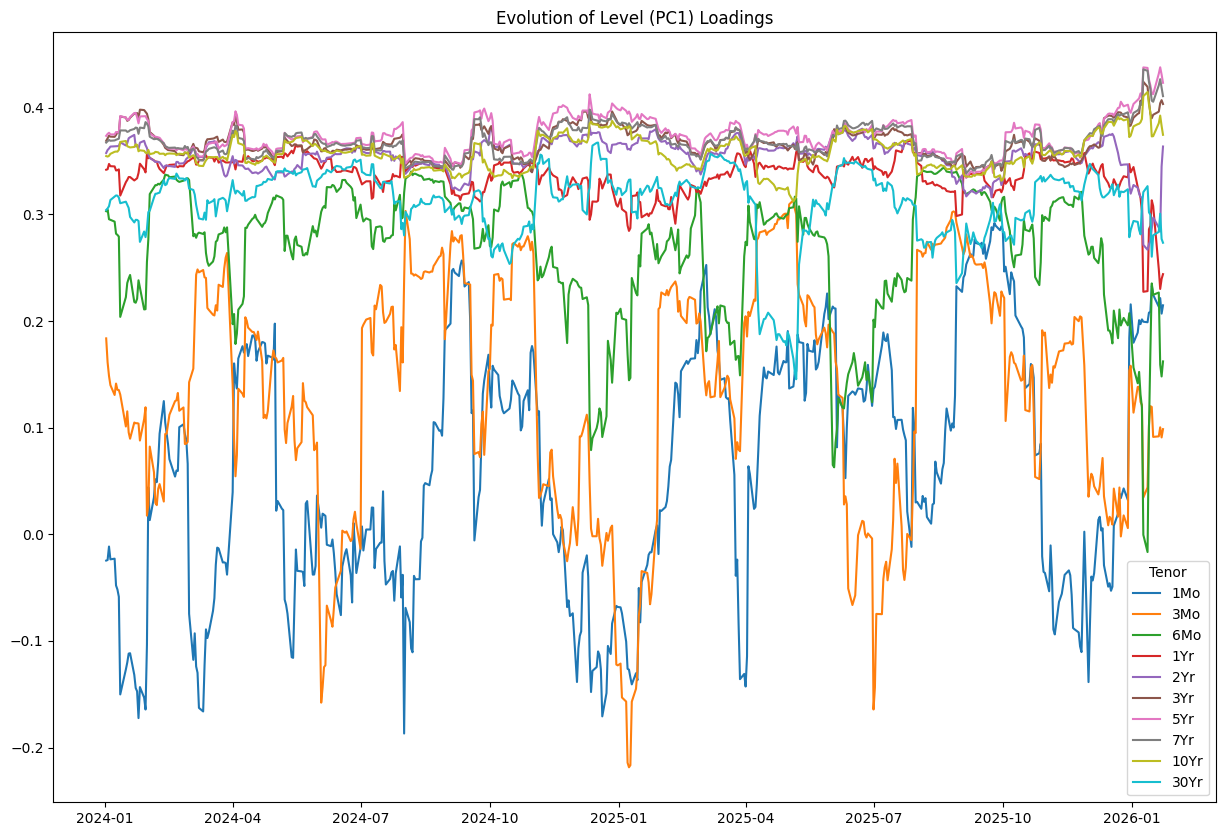

In [36]:
# Isolate only PC1 across all tenors
pc1_loadings = rolling_loadings['PC1_Level']
pc1_loadings.plot(figsize=(15,10), title="Evolution of Level (PC1) Loadings")

<Axes: title={'center': '10Yr Sensitivity to Level, Slope, and Curvature'}>

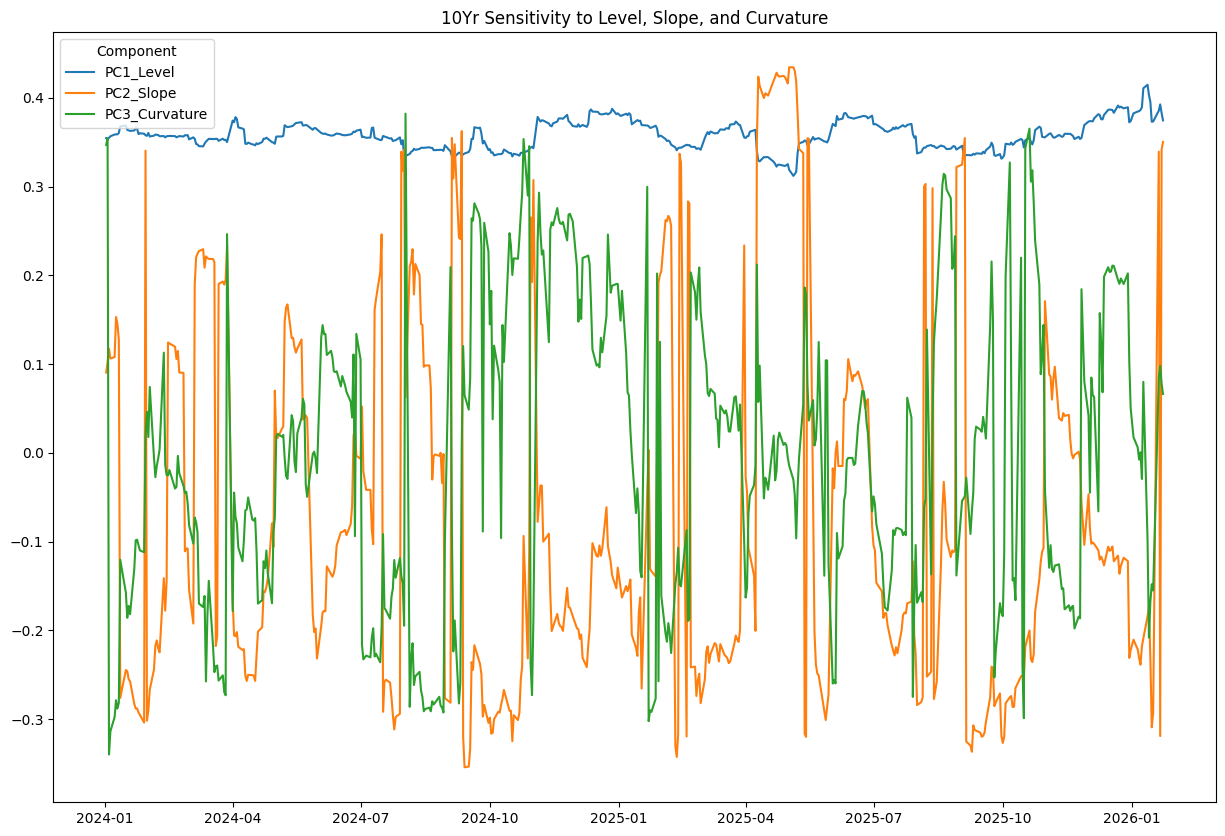

In [37]:
# Isolate the 10Yr tenor across the 3 components
ten_year_betas = rolling_loadings.xs('10Yr', level='Tenor', axis=1)
ten_year_betas.plot(figsize=(15,10), title="10Yr Sensitivity to Level, Slope, and Curvature")

<Axes: title={'center': '5-Year Curvature Loading (Alpha Signal)'}>

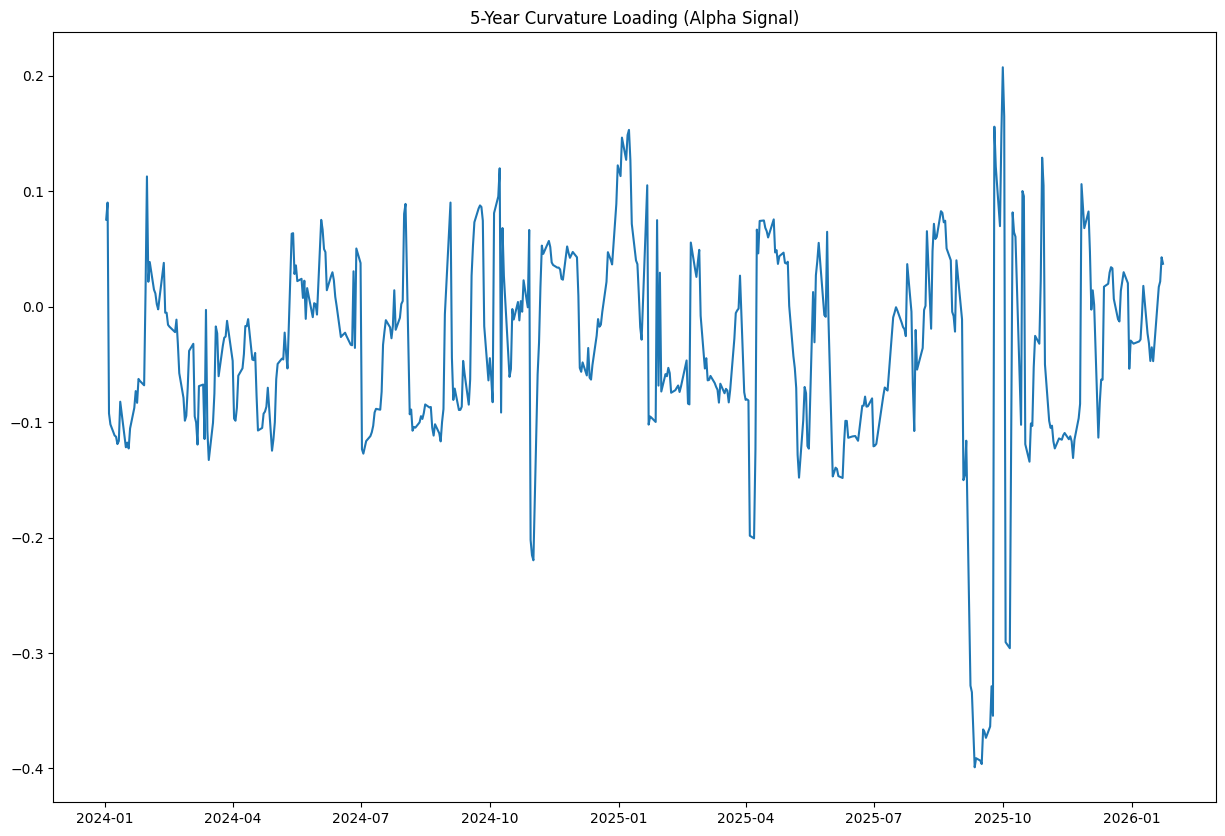

In [39]:
# Isolate PC3 (Curvature)
pc3_loadings = rolling_loadings['PC3_Curvature']
# Look specifically at the 5Y - if this loading spikes, the 'Belly' is moving idiosyncraticly
pc3_loadings['5Yr'].plot(figsize=(15,10), title="5-Year Curvature Loading (Alpha Signal)")

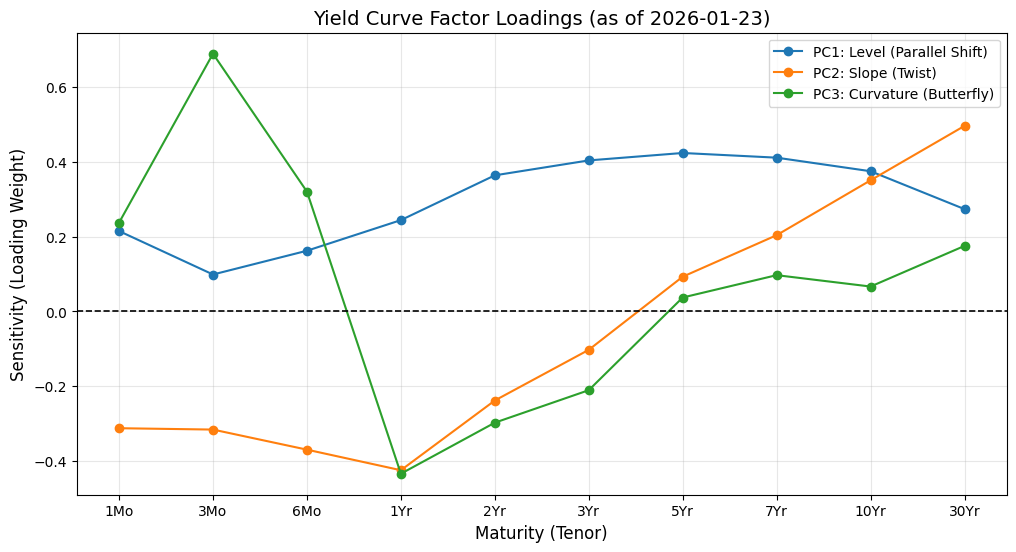

In [48]:

def plot_latest_loadings(rolling_loadings_df):
    # 1. Grab the most recent date of data
    latest_date = rolling_loadings_df.index[-1]
    latest_loadings = rolling_loadings_df.loc[latest_date]
    
    # 2. Set up the plot
    plt.figure(figsize=(12, 6))
    tenors = ['1Mo', '3Mo', '6Mo', '1Yr', '2Yr', '3Yr', '5Yr', '7Yr', '10Yr', '30Yr']
    
    # 3. Plot each component
    # We use .xs to pull the specific component across all tenors
    plt.plot(tenors, latest_loadings['PC1_Level'], marker='o', label='PC1: Level (Parallel Shift)')
    plt.plot(tenors, latest_loadings['PC2_Slope'], marker='o', label='PC2: Slope (Twist)')
    plt.plot(tenors, latest_loadings['PC3_Curvature'], marker='o', label='PC3: Curvature (Butterfly)')
    
    # 4. Formatting for a professional look
    plt.axhline(0, color='black', linestyle='--', linewidth=1.2)
    plt.title(f"Yield Curve Factor Loadings (as of {latest_date})", fontsize=14)
    plt.xlabel("Maturity (Tenor)", fontsize=12)
    plt.ylabel("Sensitivity (Loading Weight)", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    return plt.show()

# Run the plot
plot_latest_loadings(rolling_loadings)